In [3]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [4]:
path = 'https://stepik.org/media/attachments/lesson/396012/hw_aa.csv'

In [5]:
df = pd.read_csv(path, sep=';', usecols = ['experimentVariant','version','purchase'])

In [6]:
df.head()

,experimentVariant,version,purchase
0,1,v2.8.0,0
1,0,v2.9.0,0
2,1,v2.9.0,0
3,1,v2.8.0,0
4,1,v2.8.0,0


In [7]:
df.dtypes

experimentVariant     int64
version              object
purchase              int64
dtype: object

In [10]:
df.shape[0] #размер ГС

127018

### Проверяем на общей выборке (все версии приложения)

In [11]:
a, n_objs, n_sims = 0.05, 1000, 1000 #альфа, размер выборки, кол-во симуляций

In [15]:
results = []
for i in tqdm(range(n_sims)):
    serie_1 = df[df.experimentVariant==0].purchase.sample(n_objs, replace = False).values
    serie_2 = df[df.experimentVariant==1].purchase.sample(n_objs, replace = False).values
    results.append(stats.ttest_ind(serie_1, serie_2, equal_var = False)[1]) # сохраняем pvalue)

- p-value > a - принимаем H0
- p-value < a - отвергаем H0
- FP (**F**alse **P**ositive) - вероятность ложного отклонения нулевой гипотезы

In [17]:
# Для A-A теста мы бы всегда принимали HO, но на деле она в части симуляций отвергалась - как часто?
FPR = sum(np.array(results) < a) / n_sims; FPR

0.932

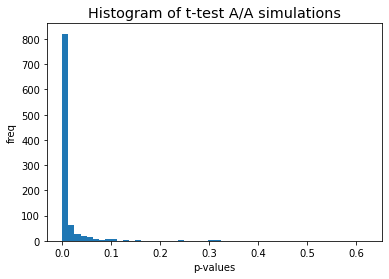

In [18]:
plt.hist(results, bins = 50)
plt.style.use('ggplot')
plt.xlabel('p-values')
plt.ylabel('freq')
plt.title('Histogram of t-test A/A simulations')
plt.show()

### Для дальнейших тестов "обернём" алгоритм теста в функцию

In [19]:
def aa_test(d1, d2, a=0.05, n_objs=1000, n_sims=1000, ver = ''):
    results = []
    for i in tqdm(range(n_sims)):
        results.append(
            stats.ttest_ind(
                d1.sample(n_objs, replace = False).values,
                d2.sample(n_objs, replace = False).values,
                equal_var = False)[1])
    
    plt.hist(results, int(np.sqrt(n_sims)))
    plt.style.use('ggplot')
    plt.xlabel('p-values')
    plt.ylabel('freq')
    plt.title('Histogram of t-test A/A simulations -{}'.format(ver))
    plt.show()
    
    FPR = sum(np.array(results) < a) / n_sims
    print('FPR is {}, alpha is {}'.format(FPR, a))

### Запускаем тест для каждой версии приложения отдельно, выводим FPR, гистрограмму и конверсию

In [21]:
versions = np.array(df.version.value_counts().index).tolist(); versions #получаем уникальные значения версий

['v2.8.0', 'v2.9.0', 'v3.8.0.0', 'v3.7.4.0']

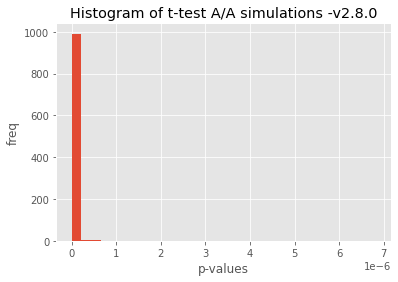

FPR is 1.0, alpha is 0.05
conversion: 0.02337176314359872


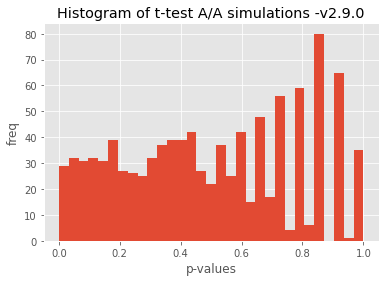

FPR is 0.046, alpha is 0.05
conversion: 0.07297319863070886


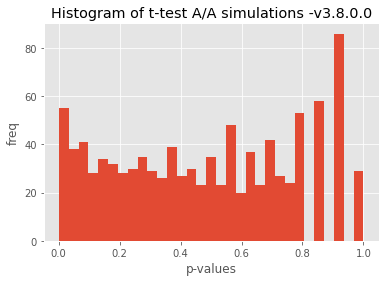

FPR is 0.073, alpha is 0.05
conversion: 0.0603185360894612


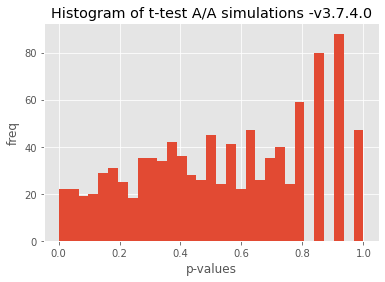

FPR is 0.034, alpha is 0.05
conversion: 0.06148367952522255


In [22]:
for v in range(len(versions)):
    a = df.loc[ (df.version==versions[v]) & (df.experimentVariant==0), 'purchase']
    b = df.loc[ (df.version==versions[v]) & (df.experimentVariant==1), 'purchase']
    aa_test(d1=a, d2=b, ver = versions[v])
    conversion = (a.sum() + b.sum()) / (a.count() + b.count())
    print('conversion : {}'.format(conversion))

In [23]:
#видим что в первой версии 'v2.8.0' значительно ниже конверсия, чем в остальных

### Запускаем тест исключив из ГС данные о версии 2.8.0

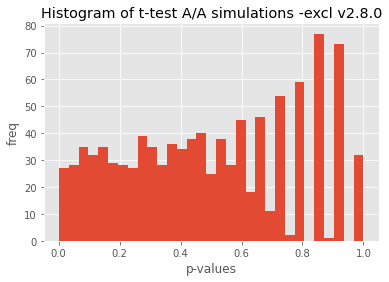

FPR is 0.039, alpha is 0.05
conversion: 0.06148367952522255


In [27]:
a_upd = df.loc[ (df.version != 'v2.8.0') & (df.experimentVariant==0), 'purchase']
b_upd = df.loc[ (df.version != 'v2.8.0') & (df.experimentVariant==1), 'purchase']
aa_test(d1=a_upd, d2=b_upd, a = 0.05, ver = 'excl v2.8.0')
conversion_upd = (a.sum() + b.sum()) / (a.count() + b.count())
print('conversion: {}'.format(conversion_upd))

In [ ]:
#FPR = порогу значимости альфа

In [28]:
#результат FPR <= порога значимости, систему сплитования можем считать работоспособной